<a href="https://colab.research.google.com/github/mahesh-keswani/pytorch-example-notebook/blob/main/14_PytorchLSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
FILE = 'ADANIPORTS.csv'
df = pd.read_csv(FILE)

In [3]:
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [4]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
3317,2021-04-26,ADANIPORTS,EQ,725.35,733.0,739.65,728.90,729.2,730.75,733.25,9390549,6.885658e+14,116457.0,838079,0.0892
3318,2021-04-27,ADANIPORTS,EQ,730.75,735.0,757.50,727.35,748.6,749.15,747.67,20573107,1.538191e+15,236896.0,1779639,0.0865
3319,2021-04-28,ADANIPORTS,EQ,749.15,755.0,760.00,741.10,743.4,746.25,751.02,11156977,8.379106e+14,130847.0,1342353,0.1203
3320,2021-04-29,ADANIPORTS,EQ,746.25,753.2,765.85,743.40,746.4,746.75,753.06,13851910,1.043139e+15,153293.0,1304895,0.0942
3321,2021-04-30,ADANIPORTS,EQ,746.75,739.0,759.45,724.50,726.4,730.05,743.35,12600934,9.366911e+14,132141.0,3514692,0.2789


In [5]:
# so we can see we have data from 2007 to 2021

# Lets start by doing in the wrong way by  just using prices
series = df['Close'].values.reshape(-1, 1)
N = len(series)
scaler = StandardScaler()
scaler.fit(series[:N//2])
series = scaler.transform(series).flatten()

In [6]:
# Lets build this using the code  we  have previously  worked with
T = 20
D = 1
X = []
Y = []
for t in range(N - T):
    X.append(series[t : t + T])
    Y.append(series[t + T])


X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(3302, 20, 1) (3302,)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dimension, hidden_dimension, output_dimension, n_layers):
        super(SimpleLSTM, self).__init__()

        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size = input_dimension,
            hidden_size = hidden_dimension,
            num_layers = n_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dimension).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dimension).to(device)

        lstm_out, _ = self.lstm(x, (h0, c0))

        # we only want the hidden state  only at the final timestep
        y_pred = self.fc(lstm_out[:, -1, :])
        return y_pred

In [9]:
model = SimpleLSTM(1, 10, 1, 2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [10]:
X_train = torch.from_numpy(X[:N//2]).float().to(device)
Y_train = torch.from_numpy(Y[:N//2]).float().to(device)
X_test = torch.from_numpy(X[N//2:]).float().to(device)
Y_test = torch.from_numpy(Y[N//2:]).float().to(device)

In [11]:
EPOCHS = 200
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = criterion(y_pred, Y_train)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    test_preds = model(X_test)
    test_loss = criterion(test_preds, Y_test)
    test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1651])) that is different to the input size (torch.Size([1651, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/200, Train Loss: 0.9150, Test Loss: 0.1312
Epoch 20/200, Train Loss: 0.9126, Test Loss: 0.1389
Epoch 30/200, Train Loss: 0.9121, Test Loss: 0.1351
Epoch 40/200, Train Loss: 0.9120, Test Loss: 0.1351
Epoch 50/200, Train Loss: 0.9120, Test Loss: 0.1365
Epoch 60/200, Train Loss: 0.9120, Test Loss: 0.1353
Epoch 70/200, Train Loss: 0.9120, Test Loss: 0.1354
Epoch 80/200, Train Loss: 0.9120, Test Loss: 0.1358
Epoch 90/200, Train Loss: 0.9120, Test Loss: 0.1357
Epoch 100/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 110/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 120/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 130/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 140/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 150/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 160/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 170/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 180/200, Train Loss: 0.9120, Test Loss: 0.1356
Epoch 190/200, Train Loss: 0.9120, Test Loss: 0.1356
Ep

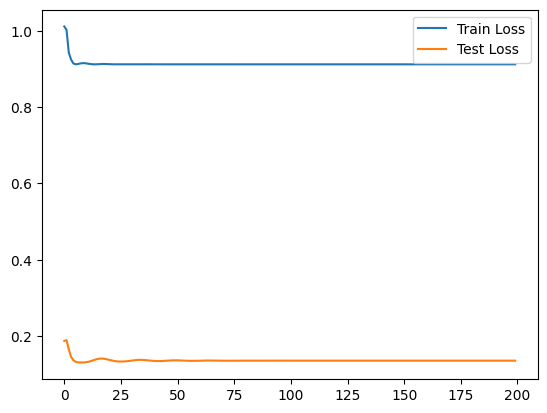

In [12]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()

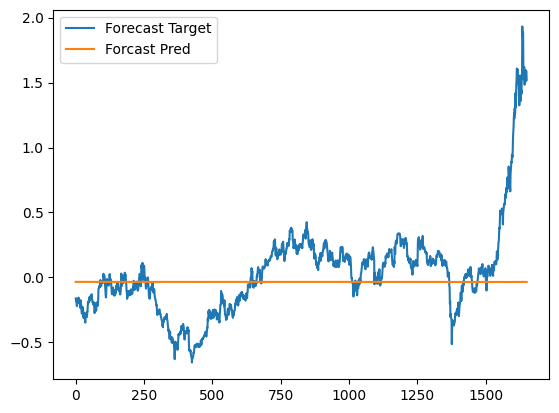

In [13]:
# WRONG forecast using true targets
validation_targets = Y[N//2:]
validation_predictions = []

i = 0
while len(validation_predictions) < len(validation_targets):
    input = X_test[i].view(1, T, 1)
    pred = model(input)[0, 0].item() # 1x1 array to scaler
    validation_predictions.append(pred)
    i += 1

plt.plot(validation_targets, label = 'Forecast Target')
plt.plot(validation_predictions, label = 'Forcast Pred')
plt.legend()

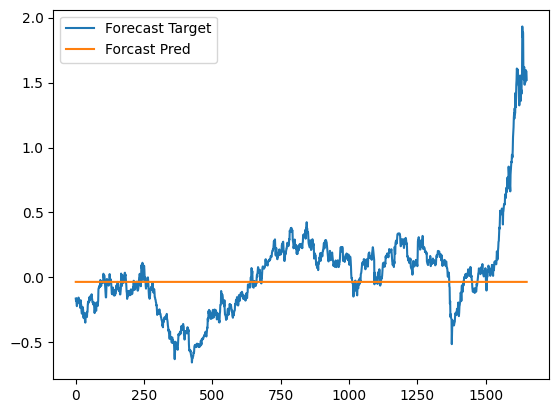

In [14]:
# Ideally we should forecast future values using slf-predictions instead of using true targets
validation_targets = Y[N//2:]
validation_preds = []

# get the last train input, and we will use it to forecast multistep values
last_x = torch.from_numpy(X[-N//2].astype(np.float32)).to(device)
i = 0
while len(validation_preds) < len(validation_targets):
    pred = model(last_x.view(1, T, 1))

    # pred is 2d dimension of shape [1,1], last_x is 2d dimension of shape  [20,1]
    validation_preds.append(pred[0, 0].item())
    # if last_x was [1,2,3] we  predict 4, now  we update last_x to [2,3,4] i.e using self predictions
    last_x = torch.cat((last_x[1:], pred))
    i += 1

plt.plot(validation_targets, label = 'Forecast Target')
plt.plot(validation_preds, label = 'Forcast Pred')
plt.legend()